In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import check_grad
from scipy.optimize import approx_fprime
from matplotlib import pyplot as plt
#%%
'''
    mx: mean of source with size: n x 1
    M: means of target distributions with size: n x K, where K indicates number of data-classes.
    covx: covariance matrix of source with size: n x 1
    covM: array of covariance matrices of target distributions with size: K x n x n, where K indicates number of data-classes.
    max_iter: max_iterations of Frank Wolfe
    tol: tolerance for gradient check
    divg: divergences to be used for computations
    max_iter: maximum of frank wolfe iterations
    min_tol: minimum tolerance for gardient checking
    print_iter: priniting values of maixture weights for each iteration
'''
class GM_FW:
    def __init__(self, mux, M, covx, covM, c0,  max_iter = None, min_tol = None, print_iter = None):
        # instance attributes which should be initilzied with class
        self.mux = mux
        self.M = M
        self.covx = covx
        self.covM = covM
        self.c0 = c0
        
        self.sqrt_covx = sp.linalg.sqrtm(covx)
        self.I = np.identity(np.size(mux))

        # attributes to be keep track of computations
        self.c = np.zeros_like(c0)
        self.mubar = np.zeros_like(mux)
        self.hat_covM = self.covM + self.M.T.reshape([self.M.shape[1], self.M.shape[0], 1]) @ self.M.T.reshape([M.shape[1], 1, M.shape[0]])
        self.tilde_covM = np.zeros_like(covM)
        self.tilde_sigma_c = np.zeros([covM.shape[1], covM.shape[2]])
        self.zeta_c = np.zeros([covM.shape[1], covM.shape[2]])
        
        if max_iter == None:
            self.max_iter = 1000
        else:
            self.max_iter = max_iter

        if min_tol == None:
            self.min_tol = 1e-6
        else:
            self.min_tol = min_tol
        
        if print_iter == None:
            self.print_iter = False
        elif print_iter == False:
            self.print_iter = False
        elif print_iter == True:
            self.print_iter = True
        else:
            self.print_iter = False

        self.obj_vals = np.zeros([self.max_iter])
        self.grads = np.zeros([self.max_iter, np.size(self.c)])
        self.weights = np.zeros([self.max_iter, np.size(self.c)])
    
    def reset_values(self):
        # self.mux = mux
        # self.M = M
        # self.covx = covx
        # self.covM = covM
        # self.c0 = c0
        # self.divg = divg

        self.sqrt_covx = sp.linalg.sqrtm(self.covx)
        self.I = np.identity(np.size(self.mux))

        # attributes to be keep track of computations
        self.c = np.zeros_like(self.c0)
        self.mubar = np.zeros_like(self.mux)
        self.hat_covM = self.covM + \
            self.M.T.reshape([self.M.shape[1], self.M.shape[0], 1]
                        ) @ self.M.T.reshape([self.M.shape[1], 1, self.M.shape[0]])
        self.tilde_covM = np.zeros_like(self.covM)
        self.tilde_sigma_c = np.zeros([self.covM.shape[1], self.covM.shape[2]])
        self.zeta_c = np.zeros([self.covM.shape[1], self.covM.shape[2]])

        # if max_iter == None:
        #     self.max_iter = 1000
        # else:
        #     self.max_iter = max_iter

        # if min_tol == None:
        #     self.min_tol = 1e-6
        # else:
        #     self.min_tol = min_tol

        # if print_iter == None:
        #     self.print_iter = False
        # elif print_iter == False:
        #     self.print_iter = False
        # elif print_iter == True:
        #     self.print_iter = True
        # else:
        #     self.print_iter = False

        self.obj_vals = np.zeros([self.max_iter])
        self.grads = np.zeros([self.max_iter, np.size(self.c)])
        self.weights = np.zeros([self.max_iter, np.size(self.c)])

    def initialize_weights(self):
        self.c = self.c0

    def compute_mubar(self):
        self.mubar =  np.sum(self.c[np.newaxis,:] * self.M, axis = 1, keepdims = True)
    
    def compute_mmd(self):
        return np.linalg.norm(self.mux - self.M@self.c)**2
    
    def compute_mmd_grad(self):
        return 2*self.M.T @ (self.M @ self.c[:,np.newaxis] - self.mux)

    def compute_tilde_covM(self):
        self.tilde_covM = self.hat_covM - (self.mubar@self.mubar.T)[np.newaxis,:,:]

        
    def compute_tilde_sigma_c(self):
        self.tilde_sigma_c = np.sum(
            self.c[:, np.newaxis, np.newaxis] * self.tilde_covM, axis=0)
            
    def compute_zeta_c(self):
        temp = sp.linalg.sqrtm(self.sqrt_covx @ self.tilde_sigma_c @ self.sqrt_covx)
        self.zeta_c = (temp + temp.T)/2

    def compute_bures(self):
        temp =  np.trace( self.covx + self.tilde_sigma_c - 2 * self.zeta_c )
        return temp
    
    def compute_bures_grad_tilde_sigma_c(self):
        return self.I - self.sqrt_covx @ sp.linalg.pinv(self.zeta_c) @ self.sqrt_covx
    
    def compute_bures_grad_c(self):
        G = self.compute_bures_grad_tilde_sigma_c()
        rho = (self.M.T.reshape(self.M.shape[1], self.M.shape[0],1) @ self.mubar.T) + self.mubar @ self.M.T.reshape(self.M.shape[1],1,self. M.shape[0])
        temp = np.sum(G[np.newaxis, :, :] * (self.hat_covM - rho ), axis=(1, 2))[:, np.newaxis]
        return temp
    
    def compute_frechet(self):
        B = self.compute_bures()
        mmd = self.compute_mmd()
        return B + mmd

    def compute_frechet_grad(self):
        GB = self.compute_bures_grad_c()
        Gmmd = self.compute_mmd_grad()
        return GB + Gmmd


    def FW_frechet_routine(self):
        self.initialize_weights()
        for i in range(0, self.max_iter):
            self.compute_mubar()
            self.compute_tilde_covM()
            self.compute_tilde_sigma_c()
            self.compute_zeta_c()
            self.compute_bures_grad_c()
            self.obj_vals[i] = self.compute_frechet()
            g = self.compute_frechet_grad()
            #print(g)
            self.grads[i, :] = np.squeeze(g)
            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c + gamma * s
            
            self.weights[i, :] = self.c
            if self.print_iter == True:
                print("iter = ",i)
                print("\n c = ",self.c)
                
    
    def FW_Bures_routine(self):

        # commented part must be uncommented for gradient-checking
        def bures(c_i):
            mubar =  np.sum(c_i[np.newaxis,:] * self.M, axis = 1, keepdims = True)
            tilde_covM = self.hat_covM - (mubar@mubar.T)[np.newaxis,:,:]
            
            tilde_sigma_c = np.sum(c_i[:, np.newaxis, np.newaxis] * tilde_covM, axis=0)
            zeta_ci = sp.linalg.sqrtm(self.sqrt_covx @ tilde_sigma_c @ self.sqrt_covx)
            temp =  np.trace( tilde_sigma_c + self.covx  - 2 * zeta_ci )
            return temp
        
        def bures_grad(c_i):
            mubar =  np.sum(c_i[np.newaxis,:] * self.M, axis = 1, keepdims = True)
            #print("mubar")
            #print(mubar)
            #print("hat_covM")
            #print(self.hat_covM )
            #print("tilde_covM")
            tilde_covM = self.hat_covM - (mubar@mubar.T)[np.newaxis,:,:]
            #print(tilde_covM)
            tilde_sigma_c = np.sum(c_i[:, np.newaxis, np.newaxis] * tilde_covM, axis=0)
            #print("tilde_sigma_c")
            #print(tilde_sigma_c)
            temp = sp.linalg.sqrtm(self.sqrt_covx @ tilde_sigma_c @ self.sqrt_covx)
            zeta_ci = (temp + temp.T)/2
            #print("sqrt_covx")
            #print(self.sqrt_covx)
            #print("zeta_ci")
            #print(zeta_ci)
            G = self.I - self.sqrt_covx @ np.linalg.pinv(zeta_ci) @ self.sqrt_covx
            # print("G")
            #print(G)
            rho = (M.T.reshape(M.shape[1],M.shape[0],1) @ self.mubar.T) +  self.mubar @ M.T.reshape(M.shape[1],1,M.shape[0])
            # print("rho")
            # print(rho)
            return np.sum(G[np.newaxis, :, :] * (self.hat_covM - rho ), axis=(1, 2))
            

        self.initialize_weights()
        for i in range(0, self.max_iter):
            self.compute_mubar()
            self.compute_tilde_covM()
            self.compute_tilde_sigma_c()
            self.compute_zeta_c()
            self.compute_bures_grad_c()
            self.obj_vals[i] = self.compute_bures()
            g = self.compute_bures_grad_c()
            
            # print("g")
            # c_i = self.c
            
            # print(np.squeeze(bures_grad(c_i)))
            # #print(np.squeeze(self.compute_bures_grad_c()))

            # eps = np.sqrt(np.finfo(float).eps)/100
            # ga = sp.optimize.approx_fprime(c_i, bures, np.array([eps ,eps, eps]).T)
            # print("ga")
            # print(ga)
            
            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c + gamma * s
            self.grads[i, :] = np.squeeze(g)
            self.weights[i, :] = self.c

    def FW_MMD_routine(self):
        
        # commented part must be uncommented for gradient-checking
        
        def mmd(c_i):

            return (np.linalg.norm(self.M@c_i[:,np.newaxis] - self.mux))**2
        def mmd_grad(c_i):
            return np.squeeze(2 * self.M.T @ (self.M @ c_i[:,np.newaxis] - self.mux))
        
        self.initialize_weights()
        for i in range(0, self.max_iter):
            self.compute_mubar()
            self.compute_tilde_covM()
            self.obj_vals[i] = self.compute_mmd()

            g = self.compute_mmd_grad()

            # print("g")
            # c_i = self.c
            # print(np.squeeze(mmd_grad(c_i)))
            # #print(np.squeeze(self.compute_mmd_grad()))

            # eps = np.sqrt(np.finfo(float).eps) * 100
            
            # print("ga")
            # ga = sp.optimize.approx_fprime(c_i, mmd, np.array([eps ,eps, eps]).T)
            # print(ga)

            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c  + gamma * s 
            self.grads[i,:] = np.squeeze(g)
            self.weights[i,:] = self.c

def Hellinger(p,q):
  '''
  Function to evaluate Hellinger Distance between distributions categorical distributions p and q
  input: distributions p and q
  outputs: Hillnger distance between p and q

  '''
  assert np.all(p >= 0), "first distribution must be non-negative" 
  assert np.all(q >= 0), "second distribution must be non-negative"
  assert p.size == q.size, "input vectors must be of same size"

  p = p.reshape([p.size, 1]) 
  q = q.reshape([q.size, 1]) 

  return (1/np.sqrt(2)) * np.linalg.norm( np.sqrt(p) - np.sqrt(q))

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

from sklearn.decomposition import PCA

# Data Processing before PCA 
# N_samples indicates the number of samples to be drawn from data
N_samples = 100
Hellinger_distances = np.zeros([N_samples, 1])
# sample_sz indicates the number of samples to be drawn from data
sample_sz = 1000


tf.keras.datasets.mnist.load_data(path="mnist.npz")
(X_train, y), (X_test, yt) = keras.datasets.mnist.load_data()

X_train = X_train / 255
y = y / 1
X_test = X_test / 255
yt = yt / 1

X = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
Xt = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])


# PCA from scikit-learn

PCA_components = 130
pca = PCA(n_components = PCA_components)
pca.fit(X)
# np.sum(pca.explained_variance_ratio_)
P = pca.components_
X_hat = X@P.T
Xt_hat = Xt@P.T

# Creation and Testing and Training samples

n_classes = np.size(np.unique(y))
means_i = np.zeros([n_classes, PCA_components])
covs_i = np.zeros([n_classes, PCA_components, PCA_components])

Training_Data = {}
Training_Lables = {}
for i in range(0, 10):
  Training_Data[str(i)] = X_hat[y == i]
  Training_Lables[str(i)] = y[y == i]
  means_i[i] = np.mean(Training_Data[str(i)], axis = 0)
  covs_i[i] = np.cov(Training_Data[str(i)].T)


Testing_Data = {}
Testing_Lables = {}
for i in range(0, 10):
  Testing_Data[str(i)] = Xt_hat[yt == i]
  Testing_Lables[str(i)] = yt[yt == i]
  
# Slicing thorugh test set

Hellinger_metric = np.zeros(N_samples)

for sample_iter in range(0, N_samples): 
  sz = np.random.randint(10, 2000, [10])
  s = np.random.dirichlet(sz, 1).T
  ints = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  p = s
  counts_sample = np.floor(sample_sz * p)
  sample = np.empty([0, PCA_components], dtype = float)
  sample_labels = np.empty(0, dtype = float)
  counter = 0
  for k in ints:
    idx = np.random.choice(np.arange(0, Testing_Data[str(k)].shape[0]), size = np.int(counts_sample[counter]), replace = False )
    sample = np.append(sample, Testing_Data[str(k)][idx], axis = 0)
    sample_labels = np.append(sample_labels, Testing_Lables[str(k)][idx], axis = 0)
    counter = counter + 1

  mean_x = np.mean(sample, axis = 0)
  covx = np.cov(sample.T)

  mux = mean_x[np.newaxis,:].T
  M = means_i.T
  covM = covs_i
  


  # Frank_Wolfe is invoked
  c0 = np.ones(n_classes)/n_classes
  max_iter  = 1000
  iterations = 1000
  
  
  MNIST = GM_FW(mux, M, covx, covM, c0, max_iter = iterations, print_iter = False)
  
  MNIST.FW_frechet_routine()
  Hellinger_metric[sample_iter] = Hellinger(MNIST.c, s)
  print(Hellinger_metric[sample_iter])
  MNIST.reset_values()


0.03371788313665796
0.028518778100269537
0.031231923598794644
0.029447138890855575
0.033132798538787644
0.027940684903668092
0.05310320752365096
0.02932835104354641
0.01415388292345445
0.02659891883358177
0.02311633612925736
0.04128815028571691
0.04466552299847518
0.060519159491130466
0.029739547313409973
0.049327693444031026
0.03054683030853066
0.040787520782640925
0.047629978589809094
0.031616460842188665
0.03615884559215594
0.09245151341894946
0.02827997892457802
0.03925188979740029
0.02366888628352988
0.03124976725581939
0.04993891670179952
0.025444652613980715
0.03159394898588616
0.03868158101055158
0.018412893710031734
0.01739119207508203
0.04110615073558288
0.023617626856223112
0.019461769579964837
0.027469919312011048
0.03986736249077479
0.030768169775003056
0.02236299091690863
0.029193038101106242
0.030192755017246612
0.03011257684228783
0.032043550763917475
0.02023135971857426
0.02425832003416975
0.031953024843471504
0.038783635499689405
0.04329872972705663
0.0289179324862938

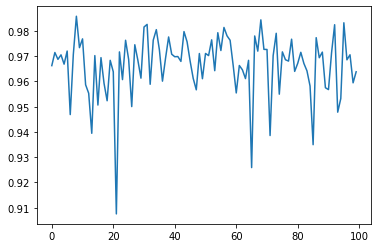

In [8]:
plt.plot(1-Hellinger_metric)

In [9]:
np.mean(1-Hellinger_metric)

0.9665505231712578

In [51]:
MNIST = GM_FW(mux, M, covx, covM, c0, max_iter=iterations, print_iter=False)
MNIST.FW_frechet_routine()


In [52]:
MNIST.c

array([0.11068531, 0.10544456, 0.05612388, 0.10858741, 0.0896044 ,
       0.10790609, 0.12062737, 0.07863137, 0.07720679, 0.14518282])

In [58]:
s

array([[0.11009988],
       [0.11382029],
       [0.06342276],
       [0.09285221],
       [0.08787182],
       [0.13226953],
       [0.11244614],
       [0.07765081],
       [0.0703646 ],
       [0.13920197]])

0.9986924910601851


In [ ]:
Fidelity = (1-Hellinger(MNIST.c, s)**2)
print(Fidelity)
